In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_curve, auc
)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [2]:
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 50
LR = 1e-4

DATASET_PATH = "/kaggle/input/datasets/sumaiyaakter4789/py-crackdb-1/Classification"

In [3]:
weights = EfficientNet_B0_Weights.DEFAULT
transform = weights.transforms()

dataset = datasets.ImageFolder(DATASET_PATH, transform=transform)

targets = dataset.targets

train_idx, val_idx = train_test_split(
    range(len(targets)),
    test_size=0.2,
    stratify=targets,
    random_state=42
)

train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("Train size:", len(train_dataset))
print("Validation size:", len(val_dataset))

Train size: 455
Validation size: 114


In [4]:
efficientnet = efficientnet_b0(weights=weights)

# Freeze backbone
for param in efficientnet.parameters():
    param.requires_grad = False

# Replace classifier for binary classification
efficientnet.classifier[1] = nn.Linear(
    efficientnet.classifier[1].in_features, 1
)

efficientnet = efficientnet.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 90.9MB/s]


In [5]:
def train_model(model):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=LR)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    start_time = time.time()

    for epoch in range(EPOCHS):
        # ---- Training ----
        model.train()
        running_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        # ---- Validation ----
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.float().unsqueeze(1).to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds = (torch.sigmoid(outputs) > 0.5).float()
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch [{epoch+1}/{EPOCHS}] "
              f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
              f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    train_time = time.time() - start_time

    history = {
        "train_loss": train_losses,
        "val_loss": val_losses,
        "train_acc": train_accs,
        "val_acc": val_accs
    }

    return model, train_time, history

In [6]:
efficientnet, train_time, history = train_model(efficientnet)

Epoch [1/50] Train Loss: 0.6761 | Val Loss: 0.6756 | Train Acc: 0.5626 | Val Acc: 0.6140
Epoch [2/50] Train Loss: 0.6144 | Val Loss: 0.5924 | Train Acc: 0.7253 | Val Acc: 0.7719
Epoch [3/50] Train Loss: 0.5776 | Val Loss: 0.5448 | Train Acc: 0.7473 | Val Acc: 0.7719
Epoch [4/50] Train Loss: 0.5397 | Val Loss: 0.5165 | Train Acc: 0.7560 | Val Acc: 0.7632
Epoch [5/50] Train Loss: 0.5128 | Val Loss: 0.4952 | Train Acc: 0.7363 | Val Acc: 0.7719
Epoch [6/50] Train Loss: 0.4991 | Val Loss: 0.4754 | Train Acc: 0.7473 | Val Acc: 0.7632
Epoch [7/50] Train Loss: 0.5028 | Val Loss: 0.4666 | Train Acc: 0.7648 | Val Acc: 0.7544
Epoch [8/50] Train Loss: 0.4541 | Val Loss: 0.4471 | Train Acc: 0.7934 | Val Acc: 0.7807
Epoch [9/50] Train Loss: 0.4597 | Val Loss: 0.4348 | Train Acc: 0.7736 | Val Acc: 0.8070
Epoch [10/50] Train Loss: 0.4337 | Val Loss: 0.4208 | Train Acc: 0.8088 | Val Acc: 0.8333
Epoch [11/50] Train Loss: 0.4396 | Val Loss: 0.4130 | Train Acc: 0.7868 | Val Acc: 0.8421
Epoch [12/50] Train

In [7]:
def evaluate_model(model):
    model.eval()

    all_labels = []
    all_preds = []
    all_probs = []

    start_time = time.time()

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)

            outputs = model(images)
            probs = torch.sigmoid(outputs).cpu().numpy()
            preds = (probs > 0.5).astype(int)

            all_labels.extend(labels.numpy())
            all_preds.extend(preds.flatten())
            all_probs.extend(probs.flatten())

    test_time = time.time() - start_time

    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)

    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "cm": cm,
        "auc": roc_auc,
        "fpr": fpr,
        "tpr": tpr,
        "test_time": test_time
    }

efficientnet_metrics = evaluate_model(efficientnet)

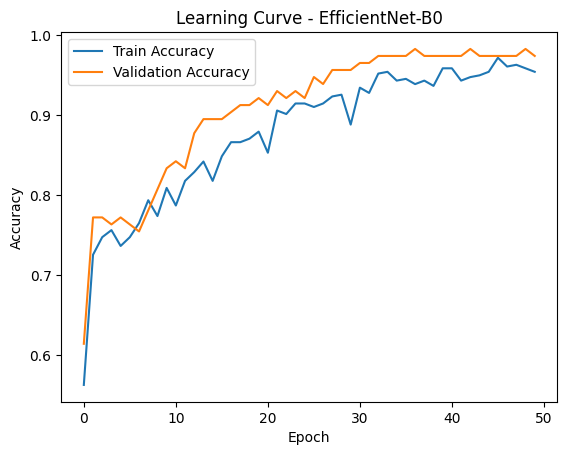

In [8]:
plt.figure()
plt.plot(history["train_acc"], label="Train Accuracy")
plt.plot(history["val_acc"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Learning Curve - EfficientNet-B0")
plt.legend()
plt.show()

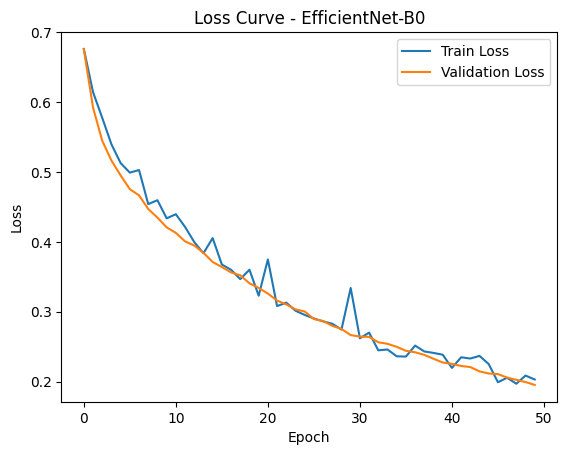

In [9]:
plt.figure()
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve - EfficientNet-B0")
plt.legend()
plt.show()

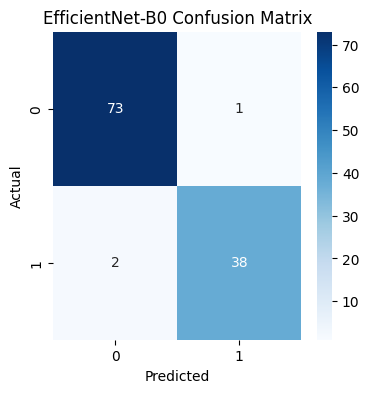

In [10]:
plt.figure(figsize=(4,4))
sns.heatmap(efficientnet_metrics["cm"], annot=True, fmt="d", cmap="Blues")
plt.title("EfficientNet-B0 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

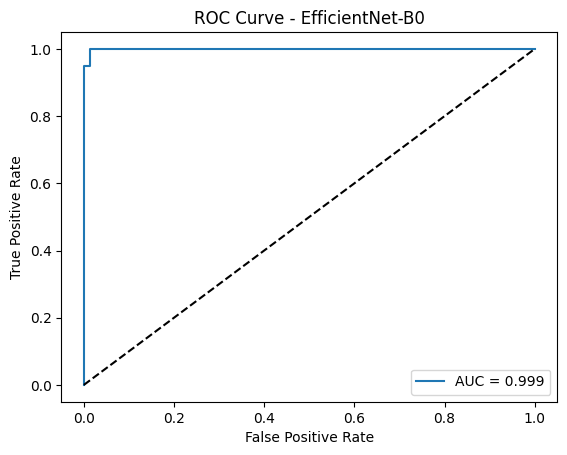

In [11]:
plt.figure()
plt.plot(efficientnet_metrics["fpr"], efficientnet_metrics["tpr"],
         label=f"AUC = {efficientnet_metrics['auc']:.3f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - EfficientNet-B0")
plt.legend()
plt.show()


In [12]:
results = pd.DataFrame({
    "Model": ["EfficientNet-B0"],
    "Accuracy": [efficientnet_metrics["accuracy"]],
    "Precision": [efficientnet_metrics["precision"]],
    "Recall": [efficientnet_metrics["recall"]],
    "F1-Score": [efficientnet_metrics["f1"]],
    "AUC": [efficientnet_metrics["auc"]],
    "Training Time (s)": [train_time],
    "Testing Time (s)": [efficientnet_metrics["test_time"]]
})

results

,Model,Accuracy,Precision,Recall,F1-Score,AUC,Training Time (s),Testing Time (s)
0,EfficientNet-B0,0.973684,0.974359,0.95,0.962025,0.999324,1789.361889,6.360862
